In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, log_loss
import numpy as np

import pandas as pd
from sklearn.utils import resample
from solution import MultinomialLogReg, OrdinalLogReg
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt


## Preprocess the data

,Transition,TwoLegged,Angle,Distance,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_F,PlayerType_G,Movement_drive,Movement_no
Transition,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TwoLegged,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.880078
Angle,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Competition_NBA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Competition_SLO1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Competition_U14,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Competition_U16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PlayerType_F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.712959,NaN,NaN
PlayerType_G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.712959,1.000000,NaN,NaN


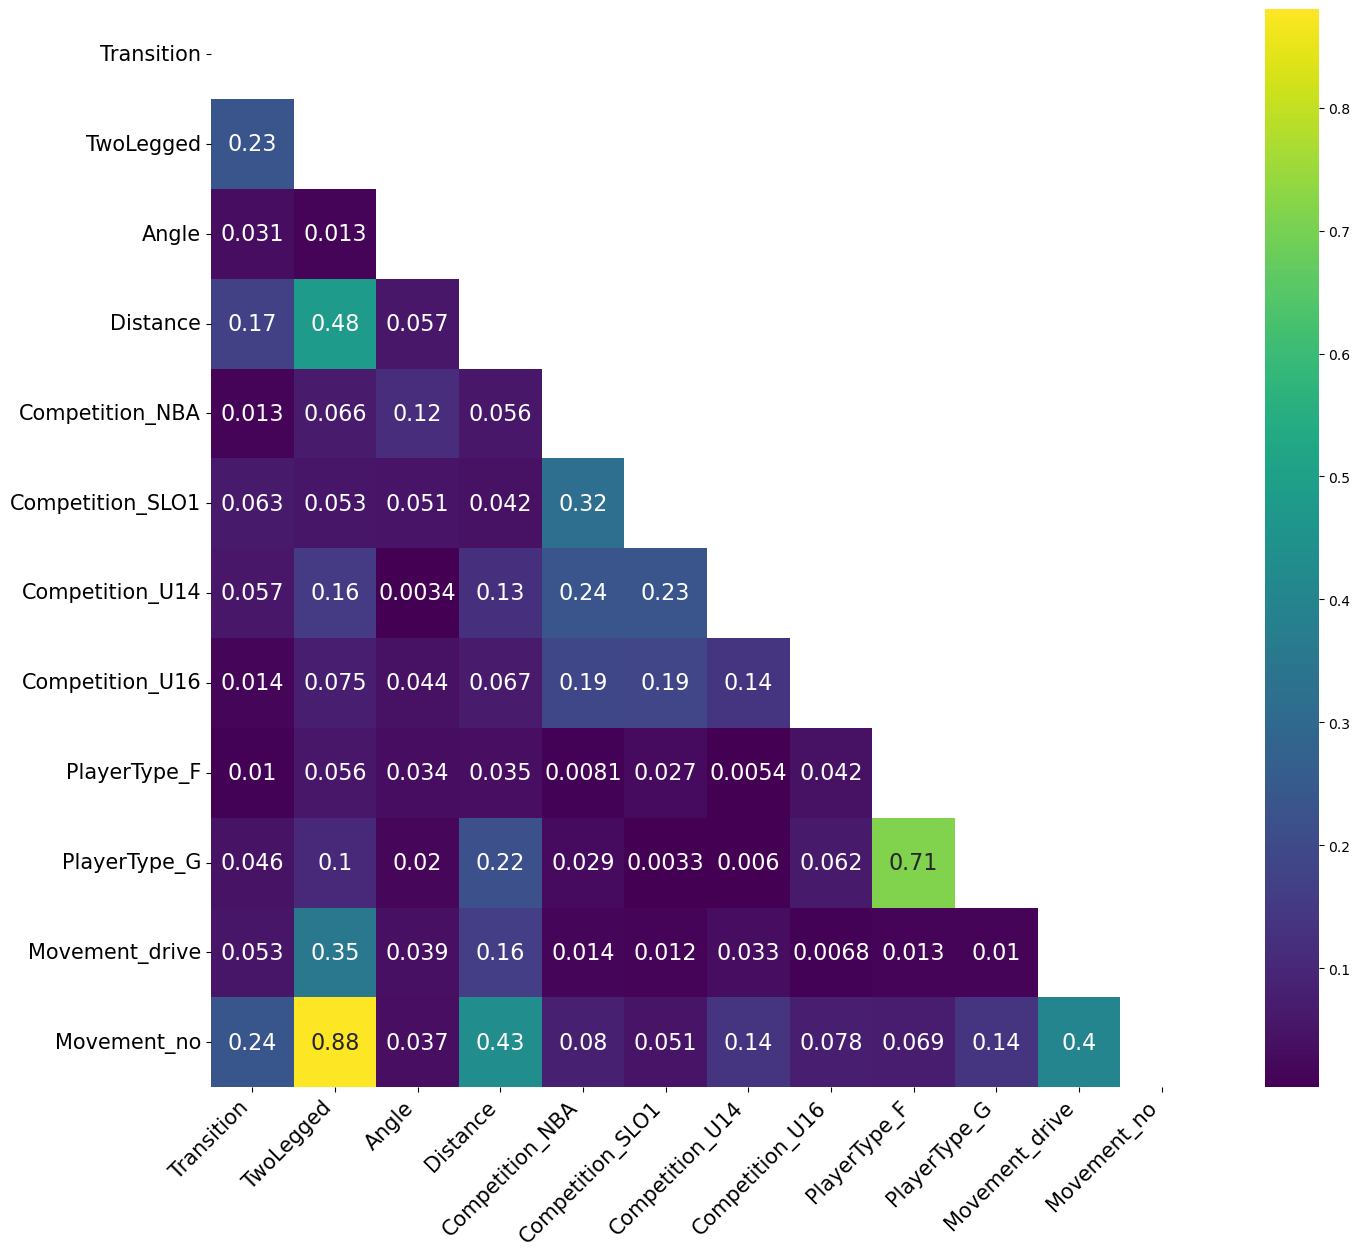

In [48]:
np.random.seed(42)
# Read the data
df = pd.read_csv("dataset.csv", sep=";")
df_og =df.copy()
# Encode the data
encoder_labs = LabelEncoder()
df["ShotType"] = encoder_labs.fit_transform(df["ShotType"])
encoder = OneHotEncoder(sparse_output=False, drop="first")
for col in ["Competition", "PlayerType", "Movement"]:
    # Fit and transform the column (convert to dense matrix)
    encoded = encoder.fit_transform(df[[col]])
    # Create new column names for the encoded columns
    encoded_columns = encoder.get_feature_names_out([col])
    # Convert the encoded array to a DataFrame with the new column names
    encoded_df = pd.DataFrame(encoded, columns=encoded_columns)
    # Drop the original column and concatenate the new encoded columns
    df = pd.concat([df.drop(columns=[col]), encoded_df], axis=1)

y = df["ShotType"].copy()
y.value_counts(), df_og["ShotType"].value_counts()

X = df.drop(columns = "ShotType")
y = df["ShotType"]


cor = X.corr()
plt.figure(figsize=(16,14))
mask = np.triu(np.abs(X.corr()))
sns.heatmap(np.abs(X.corr()), mask=mask, cmap="viridis", annot=True, annot_kws={"size": 16})
# Set the size of ticks
plt.xticks(fontsize=15, rotation=45,ha="right")
plt.yticks(fontsize=15)
plt.savefig("report/figures/corr.png")
# Drop some stuff if correlated
display(cor[abs(cor) > 0.7]) 
df = df.drop(columns=["TwoLegged", "PlayerType_F"])


In [141]:
df_og["ShotType"].value_counts()

ShotType
above head    3055
layup          973
other          439
hook shot      397
dunk            99
tip-in          61
Name: count, dtype: int64

# Testing functions on the dataset

In [20]:
def log_loss_man(y_true, y_pred_proba, eps=1e-15):
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    return -np.log(y_pred_proba[y_true])


In [ ]:
#################################
# Testing if the regressions work, with cross validation
#################################


from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mulitnomial_model = MultinomialLogReg()
ordinal_model = OrdinalLogReg()

multinomial_log_losses = []
ordinal_log_losses = []

multinomial_accs = []
ordinal_accs = []

scaler = StandardScaler()

for train_index, test_index in kf.split(X, y):
    print("split")
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scaling the relevant features
    scaler.fit(X_train[["Angle", "Distance"]])
    X_train.loc[:, ["Angle", "Distance"]] = scaler.transform(X_train[["Angle", "Distance"]])
    X_test.loc[:, ["Angle", "Distance"]] = scaler.transform(X_test[["Angle", "Distance"]])

    # Train the multinomial model
    multinomial_model_trained = mulitnomial_model.build(X_train, y_train)
    
    # Predict the probabilities and classes for multinomial
    multinomial_preds = multinomial_model_trained.predict(X_test)

    # Train the ordinal model
    ordinal_model_trained = ordinal_model.build(X_train, y_train)

    # Predict the probabilities and classes for ordinal
    ordinal_preds = ordinal_model_trained.predict(X_test)


    # Loop through test set and calculate log loss and accuracy for each data point
    for i, test_point in enumerate(test_index):
        multinomial_log_losses.append(log_loss_man(y_test.iloc[i], multinomial_preds[i]))
        ordinal_log_losses.append(log_loss_man(y_test.iloc[i], ordinal_preds[i]))

        # Accuracy for multinomial and ordinal models
        multinomial_accs.append(accuracy_score(y_test.iloc[i:i+1], np.argmax(multinomial_preds[i:i+1], axis=1)))
        ordinal_accs.append(accuracy_score(y_test.iloc[i:i+1], np.argmax(ordinal_preds[i:i+1], axis=1)))


In [25]:
# Calculate mean accuracy for multinomial model
mean_multinomial_acc = np.mean(multinomial_accs)
print(f"Mean accuracy for Multinomial Logistic Regression: {mean_multinomial_acc} +/- {np.std(multinomial_accs)/np.sqrt(len(multinomial_accs))}")

# Calculate mean accuracy for ordinal model
mean_ordinal_acc = np.mean(ordinal_accs)
print(f"Mean accuracy for Ordinal Logistic Regression: {mean_ordinal_acc}+/- {np.std(ordinal_accs)/np.sqrt(len(multinomial_accs))}")

# Calculate mean log loss for multinomial and ordinal models
mean_multinomial_log_loss = np.mean(multinomial_log_losses)
print(f"Mean log loss for Multinomial Logistic Regression: {mean_multinomial_log_loss}+/- {np.std(multinomial_log_losses)/np.sqrt(len(multinomial_accs))}")

mean_ordinal_log_loss = np.mean(ordinal_log_losses)
print(f"Mean log loss for Ordinal Logistic Regression: {mean_ordinal_log_loss}+/- {np.std(ordinal_log_losses)/np.sqrt(len(multinomial_accs))}")

Mean accuracy for Multinomial Logistic Regression: 0.7352707006369427 +/- 0.006224433335388554
Mean accuracy for Ordinal Logistic Regression: 0.7137738853503185+/- 0.006376907825276124
Mean log loss for Multinomial Logistic Regression: 0.6678471015180942+/- 0.012821744421686885
Mean log loss for Ordinal Logistic Regression: 0.9854106005981331+/- 0.018247791090017416


# Part 2.1

In [51]:
np.random.seed(42)
# Read the data
df = pd.read_csv("dataset.csv", sep=";")
df_og =df.copy()
# Encode the data
encoder_labs = LabelEncoder()
df["ShotType"] = encoder_labs.fit_transform(df["ShotType"])
encoder = OneHotEncoder(sparse_output=False, drop="first")
for col in ["Competition", "PlayerType", "Movement"]:
    # Fit and transform the column (convert to dense matrix)
    encoded = encoder.fit_transform(df[[col]])
    # Create new column names for the encoded columns
    encoded_columns = encoder.get_feature_names_out([col])
    # Convert the encoded array to a DataFrame with the new column names
    encoded_df = pd.DataFrame(encoded, columns=encoded_columns)
    # Drop the original column and concatenate the new encoded columns
    df = pd.concat([df.drop(columns=[col]), encoded_df], axis=1)

y = df["ShotType"].copy()
y.value_counts(), df_og["ShotType"].value_counts()
X = df.drop(columns = "ShotType")
y = df["ShotType"]
# Scaling the data
scaler = StandardScaler()
X.loc[:,["Angle", "Distance"]] = scaler.fit_transform(X.loc[:,["Angle", "Distance"]])

X = X.drop(columns=["TwoLegged", "PlayerType_F"])

In [ ]:
m = 100
betas = []
model = MultinomialLogReg()
for i in tqdm(range(m)):
    X_bs, y_bs = resample(X,y)
    model_pred = model.build(X_bs, y_bs)
    betas.append(model_pred.beta)
betas_means = np.mean(betas, axis=0)
betas_stds = np.std(betas, axis=0)

# Save the results
np.save("betas_means.npy", betas_means)
np.save("betas_stds.npy", betas_stds)

In [52]:
betas_means = np.load("betas_means.npy") 
betas_stds = np.load("betas_stds.npy") 
betas_means = np.vstack([betas_means ,np.zeros_like(betas_means[0]) ]) 
betas_stds = np.vstack([betas_stds ,np.zeros_like(betas_means[0])]) 

In [53]:
# Define the column names, adding 'intercept' at the beginning
columns_with_intercept = ["intercept"] + list(X.columns) 
 
# Create the DataFrame with the intercept column first
df_betas_means = pd.DataFrame(columns=columns_with_intercept, data=betas_means)
df_betas_stds = pd.DataFrame(columns=columns_with_intercept, data=betas_stds) 

labs = [i for i in range(df["ShotType"].nunique())]
shotTypes_col = encoder_labs.inverse_transform(labs) 
# HERE you have to set the correct one to 0-s, and also have to shuffle the SE-s
df_betas_means["ShotType"] = shotTypes_col 
df_betas_stds["ShotType"] = shotTypes_col
display(df_betas_means)
excluded_col = "ShotType" 
df_exp = df_betas_means.copy()
# Get the odds
for col in df_betas_means.columns:
    if col != excluded_col:
        df_exp[col] = np.exp(df_betas_means[col])
# REPORT: FMAKE A TABLE (OR GRAPH) FOR EACH OF THE ORIGINAL FEATUERES (BEFORE HOT-ENCODED), AND ONE TABLE (OR GRAPH) FOR ANGLE AND DISTANCE
# WHEN WRITIN THE REPORT LOOK AGAIN AT THE DEFINITIONS OF BASKETBALL STUFF IN THE PAPER
# INTERCEPT INTERPRETATION
# MAYBE PLOT SOME DENSITIES OF BETAS
df_betas_stds

,intercept,Transition,Angle,Distance,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_G,Movement_drive,Movement_no,ShotType
0,17.103007,-0.506545,0.357729,10.283686,0.835790,-0.050875,6.993743,2.409829,0.015023,-7.206013,-4.649533,above head
1,-6.417824,0.225680,0.198842,3.315095,1.079136,-0.171914,-7.223281,-0.144888,-0.492328,-1.266024,10.449628,dunk
2,-1.926794,-0.929633,0.104011,8.135538,0.095848,-0.068748,5.337570,1.368666,-0.399872,-1.599800,12.472725,hook shot
3,13.901030,-0.191802,0.670950,5.816858,1.110894,0.462867,7.172404,3.033785,0.129835,6.963389,-6.543263,layup
4,16.485408,-0.353577,0.366477,9.835012,0.995939,-0.411459,7.941457,3.018736,0.287326,7.430165,-6.818078,other
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,tip-in


,intercept,Transition,Angle,Distance,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_G,Movement_drive,Movement_no,ShotType
0,1.410532,0.389723,0.136478,1.015508,0.418807,0.326443,0.590276,1.333186,0.430221,1.103442,0.655926,above head
1,0.778749,0.399843,0.182202,1.220303,0.441650,0.419933,0.960617,2.281711,0.502873,0.273972,1.534144,dunk
2,0.767185,0.435628,0.131464,1.015888,0.423041,0.318341,0.628903,1.356152,0.436519,0.306913,1.214040,hook shot
3,1.435203,0.377168,0.139928,1.036417,0.456565,0.354012,0.588012,1.364886,0.435792,0.846350,0.666481,layup
4,1.393347,0.405496,0.151535,0.997261,0.411449,0.359304,0.625001,1.362445,0.434660,0.845345,0.680662,other
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,tip-in


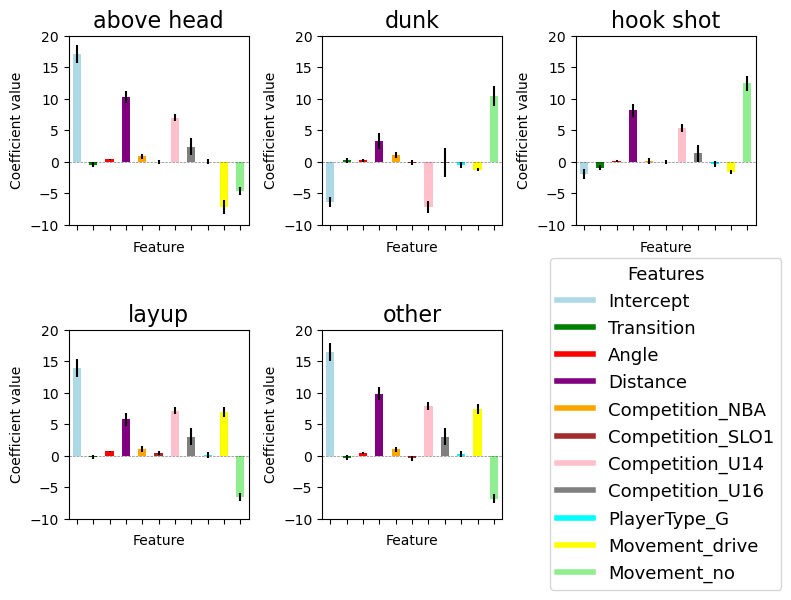

In [56]:
df_betas_filtered = df_betas_means[df_betas_means["ShotType"] != "tip-in"]
df_stds_filtered = df_betas_stds[df_betas_stds["ShotType"] != "tip-in"]
df_betas_filtered = df_betas_filtered.rename(columns={"intercept": "Intercept"})

fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes = axes.flatten()

colors = ['lightblue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'yellow', 'lightgreen']

for i in range(5):
    curr = df_betas_filtered.iloc[i, :11]
    ax = axes[i]
    se = df_stds_filtered.iloc[i, :11].values

    curr.plot(kind="bar", ax=ax, color=colors[:len(curr)], yerr=se)
    ax.axhline(y = 0, color="black", linestyle = "--", alpha=0.5, linewidth=0.5)
    ax.set_title(df_betas_filtered.iloc[i, 11], fontsize=16)
    ax.set_xticklabels([])  
    ax.set_ylim(-10,20)
    ax.set_ylabel("Coefficient value")
    ax.set_xlabel("Feature")

axes[5].axis('off')

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors[:11]]
labels = df_betas_filtered.columns[:11]

axes[5].legend(handles, labels, title="Features",title_fontsize=13, loc="center", fontsize=13)

plt.tight_layout()
plt.savefig("report/figures/betas.png")


## Part 2.2

In [74]:
def multinomial_bad_ordinal_good(num_classes=5, num_data_points=500, num_features=5):
    # Generate some random features, from the uniform distribution
    data = np.random.uniform(0,num_classes,(num_data_points, num_features)) + np.random.normal(0, 3)
    cols = [f"{i}" for i in range(num_features)]
    df = pd.DataFrame(data, columns=cols)
    # Assign the target based on the sum of the featues 
    feature_mean = df.mean(axis=1) + np.random.randn(len(df)) * 0.5 # Add a bit of gaussian noise
    # Assign the class based on the mean quantiles
    df["target"] = pd.qcut(feature_mean, q=num_classes, labels=False, duplicates="drop")
    return df

In [83]:
def multinomial_bad_ordinal_good(num_classes=5, num_data_points=500, num_features=5):
    class_len = num_data_points // num_classes
    num_data_points = num_classes * class_len
    targets = []
    rows = []
    for i in range(num_classes):
        for j in range(class_len):
            targets.append(i)
            rows.append(np.random.uniform(i - 0.5, i + 0.5, num_features) + 1.5*np.random.standard_normal(num_features))


    df = pd.DataFrame(data=rows)
    df["target"] = targets
    df= df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

In [84]:
multinomial_bad_ordinal_good().corr()

,0,1,2,3,4,target
0,1.000000,0.460584,0.451091,0.457242,0.464830,0.665508
1,0.460584,1.000000,0.497712,0.481816,0.418579,0.674331
2,0.451091,0.497712,1.000000,0.517879,0.464901,0.722290
3,0.457242,0.481816,0.517879,1.000000,0.449220,0.694917
4,0.464830,0.418579,0.464901,0.449220,1.000000,0.656879
target,0.665508,0.674331,0.722290,0.694917,0.656879,1.000000


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

accs_MN = []
log_losses_MN = []
accs_ORD = []
log_losses_ORD = []

np.random.seed(23)

# Generate dataset
df = multinomial_bad_ordinal_good(5, 200, 5)
train, test = train_test_split(df, test_size=0.5, stratify=df["target"])
X_train, y_train = train.drop(columns=["target"]), train["target"]
X_test, y_test = test.drop(columns=["target"]), test["target"]

# --- Multinomial ---
model = MultinomialLogReg()
model_pred = model.build(X_train, y_train)
pred_probs = model_pred.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)

# Accuracy
correct_preds_MN = (pred_classes == y_test.to_numpy()).astype(int)
acc_mean_MN = correct_preds_MN.mean()
acc_se_MN = correct_preds_MN.std(ddof=1) / np.sqrt(len(correct_preds_MN))

# Log loss
per_sample_losses_MN = -np.log(pred_probs[np.arange(len(y_test)), y_test])
log_loss_mean_MN = np.mean(per_sample_losses_MN)
log_loss_se_MN = np.std(per_sample_losses_MN, ddof=1) / np.sqrt(len(y_test))

# --- Ordinal ---
model = OrdinalLogReg()
model_pred = model.build(X_train, y_train)
pred_probs_ord = model_pred.predict(X_test)
pred_classes_ord = np.argmax(pred_probs_ord, axis=1)

# Accuracy
correct_preds_ORD = (pred_classes_ord == y_test.to_numpy()).astype(int)
acc_mean_ORD = correct_preds_ORD.mean()
acc_se_ORD = correct_preds_ORD.std(ddof=1) / np.sqrt(len(correct_preds_ORD))

# Log loss
per_sample_losses_ORD = -np.log(pred_probs_ord[np.arange(len(y_test)), y_test])
log_loss_mean_ORD = np.mean(per_sample_losses_ORD)
log_loss_se_ORD = np.std(per_sample_losses_ORD, ddof=1) / np.sqrt(len(y_test))

# --- Output ---
print(f"Multinomial Accuracy: {acc_mean_MN:.3f} ± {acc_se_MN:.3f}")
print(f"Multinomial Log Loss: {log_loss_mean_MN:.3f} ± {log_loss_se_MN:.3f}")
print(f"Ordinal Accuracy:     {acc_mean_ORD:.3f} ± {acc_se_ORD:.3f}")
print(f"Ordinal Log Loss:     {log_loss_mean_ORD:.3f} ± {log_loss_se_ORD:.3f}")


Multinomial Accuracy: 0.580 ± 0.050
Multinomial Log Loss: 0.942 ± 0.100
Ordinal Accuracy:     0.630 ± 0.049
Ordinal Log Loss:     0.812 ± 0.070


## Part 3

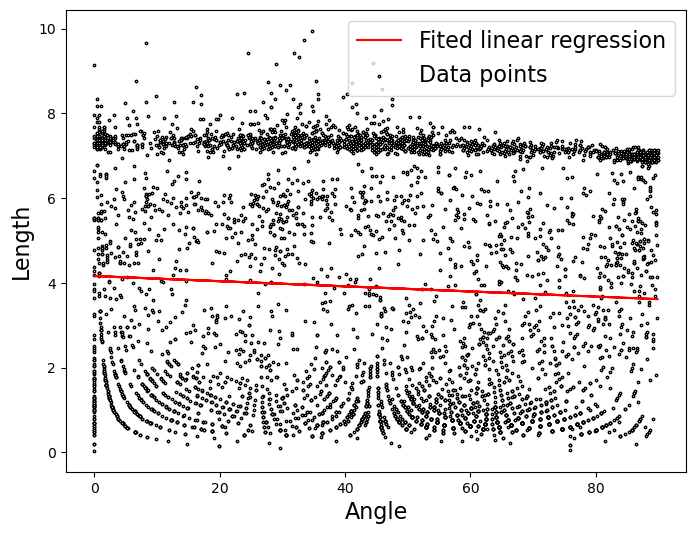

In [15]:
import matplotlib.pyplot as plt
class LinearRegression():
    def build(self, x,y):
        # Add intercept
        y = np.array(y).reshape(-1,1)
        x = np.array(x).reshape(-1,1)
        x = np.c_[np.ones_like(x),x]
        # Use the least-squares formula to get betas
        self.beta = (np.linalg.inv(x.T @ x) @ x.T) @ y
        self.hat = x @(np.linalg.inv(x.T @ x) @ x.T)
        
    def predict(self,x):
        x = np.array(x).reshape(-1,1)
        x = np.c_[np.ones_like(x),x]

        return (self.beta.T @ x.T).flatten()
    

# Get the x ans y 
df = pd.read_csv("dataset.csv", sep=";")
y = df["Distance"].values
x = df["Angle"].values

model = LinearRegression()
model.build(x,y)
preds = model.predict(x)

plt.figure(figsize=(8,6))
plt.plot(x, preds, color="red", label="Fited linear regression")
plt.scatter(x,y,color="white", s=3, edgecolors="k", label="Data points")
plt.xlabel("Angle", fontsize=16)
plt.ylabel("Length", fontsize=16)
plt.legend(fontsize=16)
plt.savefig("report/figures/lin_reg.png")

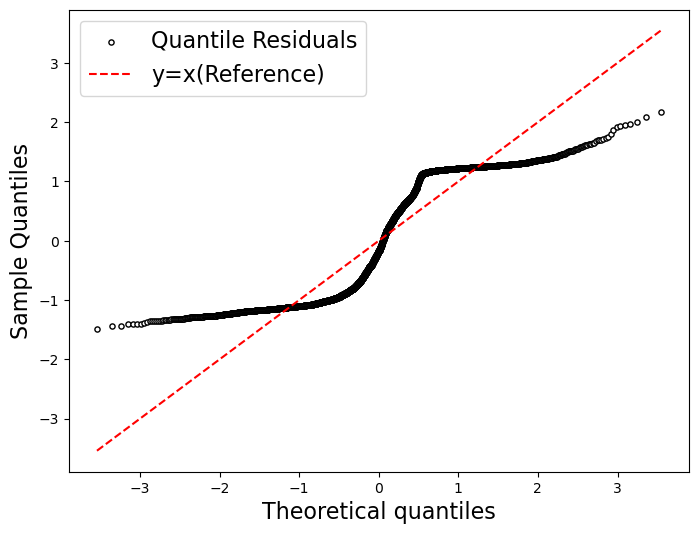

In [16]:
from scipy.stats import norm
# normal q-q plot (8.7.4)
# Get the basic residuals
response_residuals = y - preds
# Then we need the pearson residuals
quantile_residuals = response_residuals  / np.std(response_residuals)
quantile_residuals_sorted = sorted(quantile_residuals)
N = len(quantile_residuals_sorted)
probabilites = np.linspace(1/(N), N/(N+1), N)
quantiles_theory = norm.ppf(probabilites)
# Step 3: Plot Q-Q plot
plt.figure(figsize=(8,6))
plt.scatter(quantiles_theory, quantile_residuals_sorted, label="Quantile Residuals",
             color="white", s=14, edgecolors="k")
plt.plot(quantiles_theory, quantiles_theory, 'r--', label="y=x(Reference)")
plt.ylabel("Sample Quantiles", fontsize=16)
plt.xlabel("Theoretical quantiles", fontsize=16)
plt.legend(fontsize=16)
plt.savefig("report/figures/qq.png")
# Pretty clearly the distribution of residuals is not normal, it is similar to the og distribution

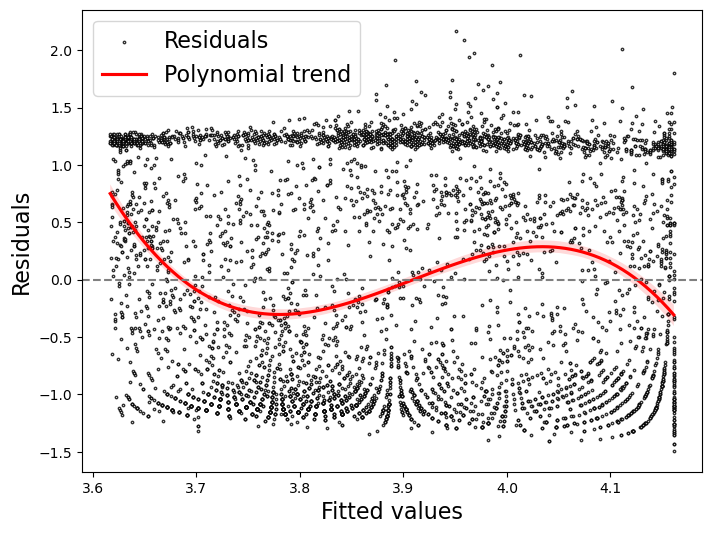

In [43]:
# residuals vs fitted values, quantile residuals
plt.figure(figsize=(8, 6))
sns.regplot(x=preds, y=quantile_residuals, scatter_kws={'color': 'white', 'edgecolors': 'black', 's': 3},
            line_kws={'color': 'red'}, order=3)  
# Add horizontal line at y=0
plt.axhline(0, color="grey", linestyle="--")

plt.xlabel("Fitted values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)
plt.legend(['Residuals','Polynomial trend'], loc='upper left', fontsize=16)
plt.savefig("report/figures/res_vs_fitted.png")

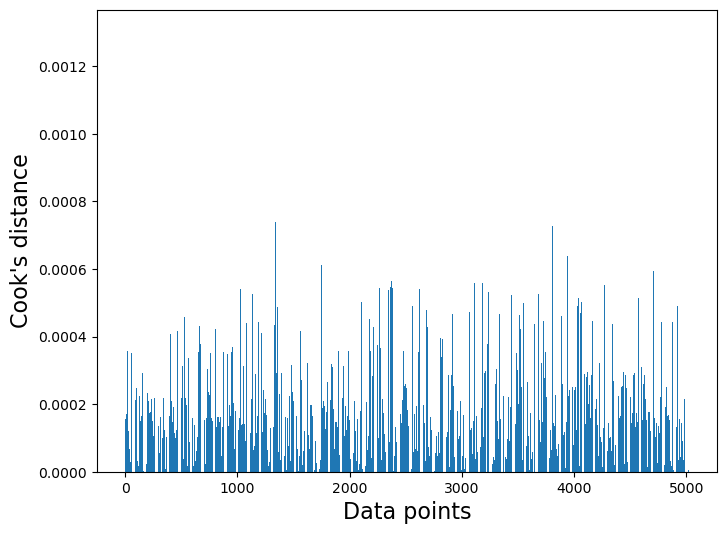

In [5]:
# Cooks distance plot
# Get the hat matrix
mse = np.mean((response_residuals)**2)
diags = np.diag(model.hat)
cook = response_residuals**2 / (2 * mse)  * diags /(1-diags)**2

plt.figure(figsize=(8,6))
plt.bar(range(len(cook)), cook)
plt.ylabel("Cook's distance", fontsize=16)
plt.xlabel("Data points", fontsize=16)
plt.savefig("report/figures/cook.png")

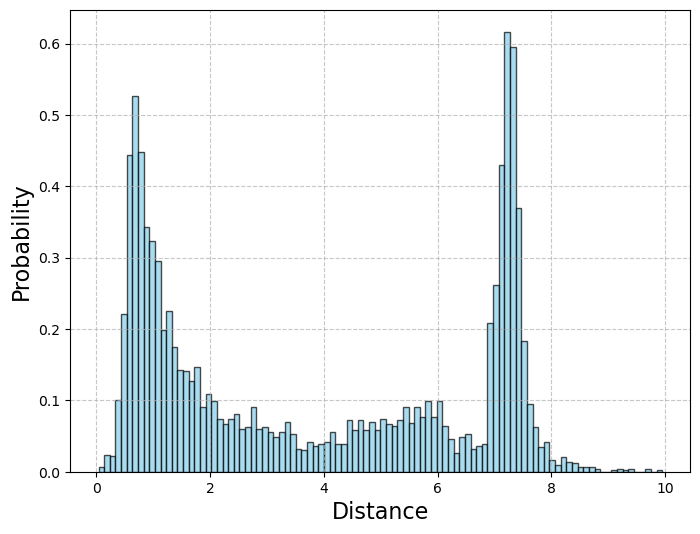

In [6]:
# plot the distribution of shot lengths
plt.figure(figsize=(8,6)) 
plt.hist(y, bins=100, color='skyblue', edgecolor='black', alpha=0.7, density=True) 


plt.xlabel('Distance', fontsize=16)
plt.ylabel('Probability', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("report/figures/distr.png")
